In [284]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm

In [285]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

logsDir = ROOT_DIR+'/logs'

goMethods=['cma', 'pso', 'bo']
seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':['popsize', 'sigma'],
	'pso':['popsize', 'w', 'c1', 'c2'],
	'bo':[['kappa', 'kappa_decay', 'kappa_decay_delay'], ['xi']]
}

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [286]:
#def plotOneVariableSweep(df, colToPlot, goMethodText=None, epsilon=0.0):
#	# x-axis = samples
#	# y-axis = percent xtime
#	# legend = colToPlot
#	df = df.copy(deep=True).reset_index(drop=True)
#
#	# progname, probsize, and method are all the same
#	assert len(list(df['progname'].unique())) == 1
#	assert len(list(df['probsize'].unique())) == 3
#	assert len(list(df['method'].unique())) == 1
#
#	progname = df.iloc[0]['progname']
#	method = df.iloc[0]['method']
#
#	# shrink what we're working with
#	df = df.drop(['progname', 'method', 'optimXtime'], axis=1)
#
#	if method == 'bo':
#		numUtilFncts = len(list(df['utilFnct'].unique()))
#		if numUtilFncts == 1:
#			util = df.iloc[0]['utilFnct']
#			df = df.drop(['utilFnct'], axis=1)
#			if ('poi' in util) or ('ei' in util):
#				df = df.drop(['kappa', 'kappa_decay', 'kappa_decay_delay'], axis=1)
#			elif 'ucb' in util:
#				df = df.drop(['xi'], axis=1)
#		# need to ignore the first sample since it's random
#		#df.loc[df['globalSample'] == 0.0, 'xtime'] = 0
#
#	if goMethodText:
#		method += f' ({goMethodText})'
#
#	# if the globalSample < popsize, 
#	# set the xtime to 0 so we don't count the point
#	if ('pso' in method) or ('cma' in method):
#		#df = df.apply(lambda row: (row['xtime']=0.0) if row['globalIdx'] < row['popsize'] else pass)
#		df.loc[df['globalSample'] < df['popsize'], 'xtime'] = 0
#
#
#	# let's manually do the precedure
#	if 'bo' in method:
#		# zero-out the first samples
#		#print('df columns', df.columns)
#		df.loc[df['globalSample'] == 0.0, 'xtime'] = 0.0
#
#		toSortBy = list(df.columns)
#		toSortBy.remove('xtime')
#		df = df.sort_values(by=toSortBy, ignore_index=True)
#
#		df['reachedOptimal'] = (df['xtime'] >= 1-epsilon).astype(int)
#
#		#print('before')
#		#print(df.head(20))
#		
#		df = df.drop(['xtime'], axis=1)
#
#		targetCols = list(df.columns)
#		#print(targetCols)
#		targetCols.remove('reachedOptimal')
#		targetCols.remove('globalSample')
#		#print('colToPlot', colToPlot, 'cumsumming over:', targetCols)
#
#
#
#		#df['sumd'] = df.groupby(['probsize', 'xi', 'seed'])['optimIndic'].cumsum().reset_index(drop=True).apply(lambda x: 1 if x != 0 else 0)
#		df['sumd'] = df.groupby(targetCols, sort=False, dropna=False)['reachedOptimal'].cumsum().reset_index(drop=True).apply(lambda x: 1 if x != 0 else 0)
#
#		#print(df.head(20))
#
#		newdf = df.groupby(['probsize', colToPlot, 'globalSample'], dropna=False)['sumd'].mean().reset_index(drop=False)#.apply(lambda x: 100.0*x['sumd'])
#		newdf['percD'] = newdf['sumd']*100
#
#		#print(newdf.head(20))
#
#		g = sns.FacetGrid(newdf, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
#		g.map_dataframe(sns.lineplot, x='globalSample', y='percD', drawstyle='steps-post')
#		g.add_legend()
#		g.set(ylim=(-0.05, 100.05))
#		#g.set(xlim=(-1, 10))
#		g.fig.subplots_adjust(top=0.85)
#		g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')
#
#		axes = g.axes.flatten()
#		axes[0].set_ylabel('Percent of Executions that find the Database Optimal \n(higher is better)')
#		for ax in axes:
#			ax.set_xlabel('Sample Index')
#			ax.axhline(y=100.0, zorder=0, ls='--')
#			axTitle = ax.get_title()
#			if 'lrgprob' in axTitle:
#				ax.set_title('Large Input')
#			elif 'medprob' in axTitle:
#				ax.set_title('Medium Input')
#			else:
#				ax.set_title('Small Input')
#
#		plt.show()
#	
#	else:
#		# it's a population-based method, plot it here with a slightly diff procedure
#
#		#print('df cols', df.columns)
#
#		toSortBy = list(df.columns)
#		toSortBy.remove('xtime')
#		df = df.sort_values(by=toSortBy, ignore_index=True)
#
#		
#		# mark the samples that actually hit an optimal policy
#		df['reachedOptimal'] = (df['xtime'] >= 1-epsilon).astype(int)
#		df = df.drop(['xtime'], axis=1)
#		df = df.dropna(axis=1, how='all')
#
#		# first need to mark which population group each sample belongs to
#		df['popgrp'] = df['globalSample']//df['popsize']
#
#		targetCols = list(df.columns)
#		targetCols.remove('reachedOptimal')
#		targetCols.remove('globalSample')
#		#print('colToPlot', colToPlot, 'averaging over:', targetCols)
#
#		# for each population group, we want to average out the indicators
#		df['grpAvrg'] = df.groupby(targetCols)['reachedOptimal'].transform('mean')
#
#		targetCols.remove('popgrp')
#		#print('colToPlot', colToPlot, 'cumsumming over:', targetCols)
#		df['sumd'] = df.groupby(targetCols)['grpAvrg'].transform('cumsum').apply(lambda x: min(1, x))
#
#		newdf = df.groupby(['probsize', colToPlot, 'globalSample'])['sumd'].mean().reset_index(drop=False)
#		newdf['percD'] = newdf['sumd']*100
#
#		#print('peeking')
#		#print(newdf.head(100))
#
#		g = sns.FacetGrid(newdf, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
#		g.map_dataframe(sns.lineplot, x='globalSample', y='percD', drawstyle='steps-post')
#		g.add_legend()
#		g.set(ylim=(-0.05, 100.05))
#		#g.set(xlim=(-0.05, 100.05))
#		g.fig.subplots_adjust(top=0.85)
#		g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')
#
#		axes = g.axes.flatten()
#		axes[0].set_ylabel('Percent of Executions that find the Database Optimal \n(higher is better)')
#		for ax in axes:
#			ax.set_xlabel('Sample Index')
#			ax.axhline(y=100.0, zorder=0, ls='--')
#			axTitle = ax.get_title()
#			if 'lrgprob' in axTitle:
#				ax.set_title('Large Input')
#			elif 'medprob' in axTitle:
#				ax.set_title('Medium Input')
#			else:
#				ax.set_title('Small Input')
#
#		plt.show()
#
#	return
#	return
#	return
#	return
#	return
#	return
#

In [290]:
def plotHeatmaps(df, targetCols, xaxis=None, titleExtra=None):
	# each df is multidimensional, for each pair of dimensions we want
	# to make a heatmap of when each configuration hits the optimal

	progname = df.iloc[0]['progname']
	methodName = df.iloc[0]['method']

	if titleExtra:
		methodName += f' ({titleExtra})'

	methodName = methodName.upper()

	# drop unneeded columns
	df = df.drop(['progname', 'method', 'optimXtime'], axis=1)

	# add this column to note which configurations hit the optimal
	df['reachedOptimal'] = (df['xtime'] == 1.0).astype(int)
	print('total number that reached optimal per problemsize', df.groupby(['probsize', 'seed'])['reachedOptimal'].sum())

	if xaxis:
		otherCols = [col for col in targetCols]
		otherCols.remove(xaxis)

	for col in otherCols:
		newTargetCols = [xaxis, col]
		newdf = df[newTargetCols+['probsize', 'globalSample', 'reachedOptimal', 'seed']].copy(deep=True)

		# technically we're not averaging across the seeds. If one seed hit the optimal, then we consider all the seeds to have gotten it.
		# we can up it to 0.75 to mean if at least 3 seeds got the optimal in that step
		#grouped = df.groupby(targetCols+['probsize', 'globalSample'])['reachedOptimal'].mean().apply(lambda x: 1 if x != 0.0 else 0).reset_index()
		grouped = newdf.groupby(newTargetCols+['probsize', 'globalSample'])['reachedOptimal'].mean().apply(lambda x: 1 if x != 0.0 else 0).reset_index()

		before = newdf.groupby(newTargetCols+['probsize', 'globalSample'])
		#print('before apply')
		for key, item in before:
			got = before.get_group(key)
			#print(got, got['reachedOptimal'].sum(), "\n\n", sep='\n')

		print('Number of configs that reached the optimal', grouped['reachedOptimal'].sum())
		print('uniques', list(newdf.groupby(newTargetCols+['probsize', 'globalSample'])['reachedOptimal'].mean().reset_index()['reachedOptimal'].unique()))

		test = grouped.groupby(newTargetCols+['probsize'])['reachedOptimal'].agg(['idxmax']).reset_index()
		testa = grouped.iloc[test['idxmax']]
		# now replace all the globalIndexes == 0.0 with -1
		testa.loc[testa['globalSample'] == 0.0, 'globalSample'] = -1
		# make the datatype integers
		testa = testa.astype({'globalSample':'int'})
		testa = testa.drop(['reachedOptimal'], axis=1)

		def drawHeatmap(*args, **kwargs):
			data = kwargs.pop('data').copy(deep=True)
			data = data.drop(['probsize'], axis=1)
			data = data.pivot(index=col, columns=xaxis, values='globalSample')
			# plot the good values
			ax = sns.heatmap(data, **kwargs)
			# plot the never found values
			sns.heatmap(data, mask=data >= 0, cmap=plt.get_cmap('binary'), vmin=-1, vmax=-1, ax=ax, cbar=False)


		g = sns.FacetGrid(testa, col='probsize', col_order=probsizes, palette='flare', height=5, aspect=1.5)
		#g.map_dataframe(sns.heatmap, annot=True, vmin=0.0, vmax=300.0)
		g.map_dataframe(drawHeatmap, annot=True, vmin=0, vmax=300, fmt='d', cbar=True)

		g.fig.subplots_adjust(top=0.85)
		g.fig.suptitle(f'Steps needed for each [{methodName}] config to reach the optimal OMP config of [{progname}]')

		axes = g.axes.flatten()
		for ax in axes:
			axTitle = ax.get_title()
			if 'lrgprob' in axTitle:
				ax.set_title('Large Input')
			elif 'medprob' in axTitle:
				ax.set_title('Medium Input')
			else:
				ax.set_title('Small Input')

		plt.show()

	return

In [291]:

def plotHeatmapsForAllCodes():
	# this plots each of the individual variables of each method
	# applied to each progname+probsize combination.
	# it averages xtimes across seeds.
	for progname in prognames:
		for method in goMethods:
			# read the pre-processed dataframe
			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data.csv'
			print('reading file', filename)
			fullDF = pd.read_csv(filename)
				
			hyps = hypers[method]
			print(progname, method, hyps)
			if method == 'bo':
				if 'kappa' in hyps:
					boDF = fullDF[fullDF['utilFnct'] == 'ucb']
					plotHeatmaps(boDF, targetCols=['kappa'], titleExtra='ucb')
				elif 'xi' in hyps:
					boDF = fullDF[fullDF['utilFnct'] == 'poi']
					plotHeatmaps(boDF, targetCols=['xi'], titleExtra='poi')
					boDF = fullDF[fullDF['utilFnct'] == 'ei']
					plotHeatmaps(boDF, targetCols=['xi'], titleExtra='ei')
			elif method == 'pso':
				plotHeatmaps(fullDF, targetCols=['popsize', 'w', 'c1', 'c2'], xaxis='popsize')
			elif method == 'cma':
				plotHeatmaps(fullDF, targetCols=['popsize', 'sigma'], xaxis='popsize')
			if method == 'pso':
				return
	return
				

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-cma-GO_Data.csv
bt_nas cma ['popsize', 'sigma']
total number that reached optimal per problemsize probsize  seed
lrgprob   1337     456
          3827     106
          4873     134
          9999       1
medprob   1337    1091
          3827     117
          4873      20
          9999     408
smlprob   1337      51
          3827      10
          4873      41
          9999       8
Name: reachedOptimal, dtype: int64
Number of configs that reached the optimal 2091
uniques [0.0, 0.25, 0.5]


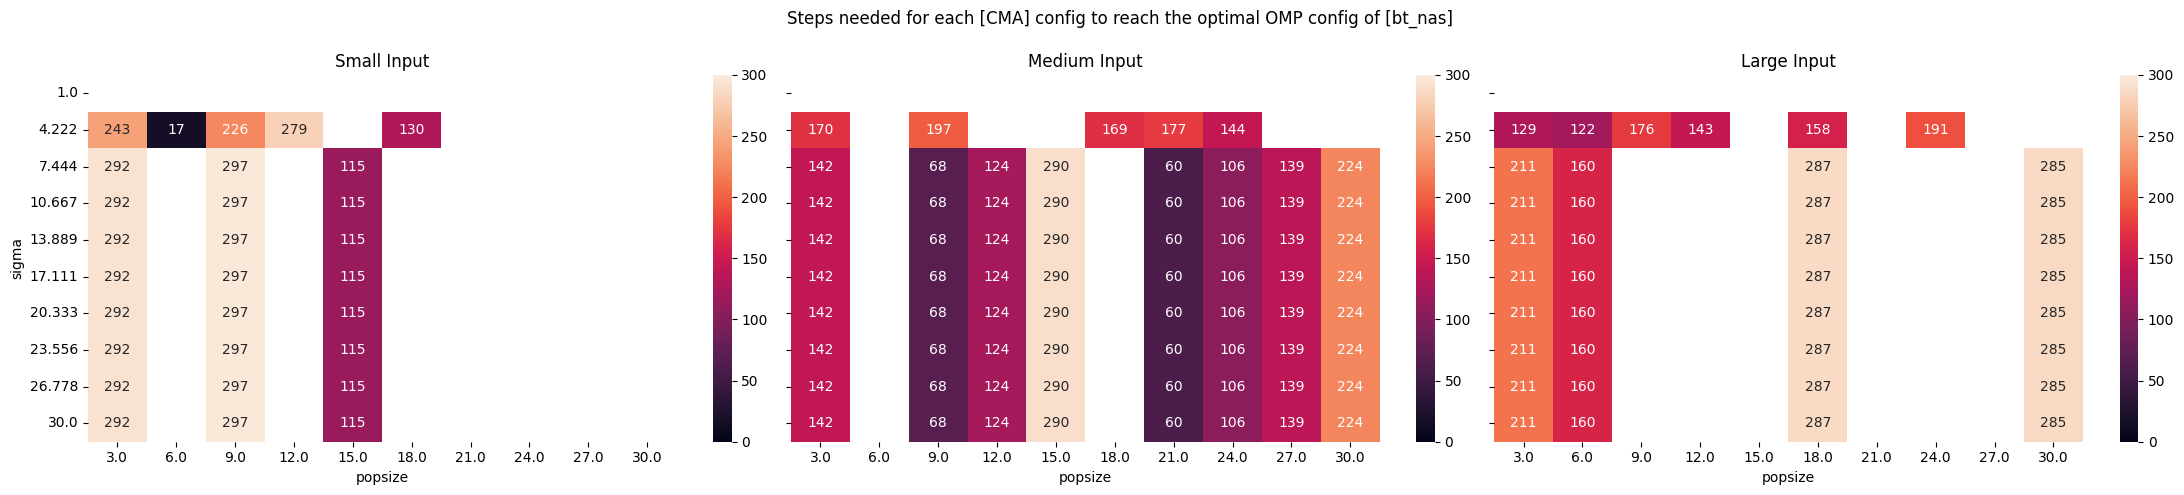

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-pso-GO_Data.csv
bt_nas pso ['popsize', 'w', 'c1', 'c2']
total number that reached optimal per problemsize probsize  seed
lrgprob   1337    13216
          3827     5762
          4873    17769
          9999     1020
medprob   1337     5156
          3827    16101
          4873    17548
          9999     6614
smlprob   1337     5447
          3827     7534
          4873    14108
          9999     6504
Name: reachedOptimal, dtype: int64
Number of configs that reached the optimal 19791
uniques [0.0, 0.05, 0.1, 0.07, 0.08, 0.06, 0.09, 0.03, 0.01, 0.04, 0.02, 0.11, 0.12, 0.14, 0.13, 0.16, 0.15, 0.17, 0.19, 0.18, 0.2, 0.22, 0.21, 0.23, 0.25, 0.24, 0.26, 0.27, 0.29, 0.3, 0.28]


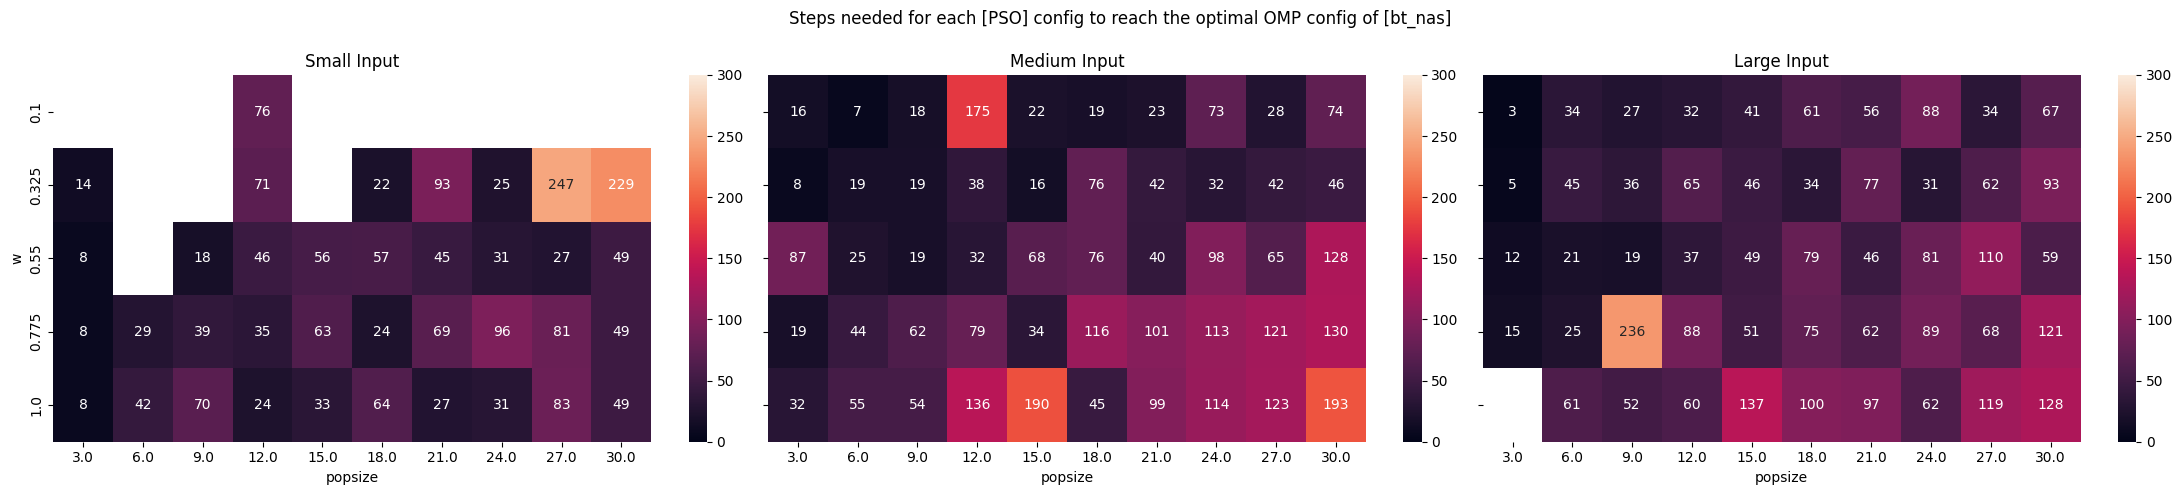

Number of configs that reached the optimal 32295
uniques [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.07, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.18, 0.15]


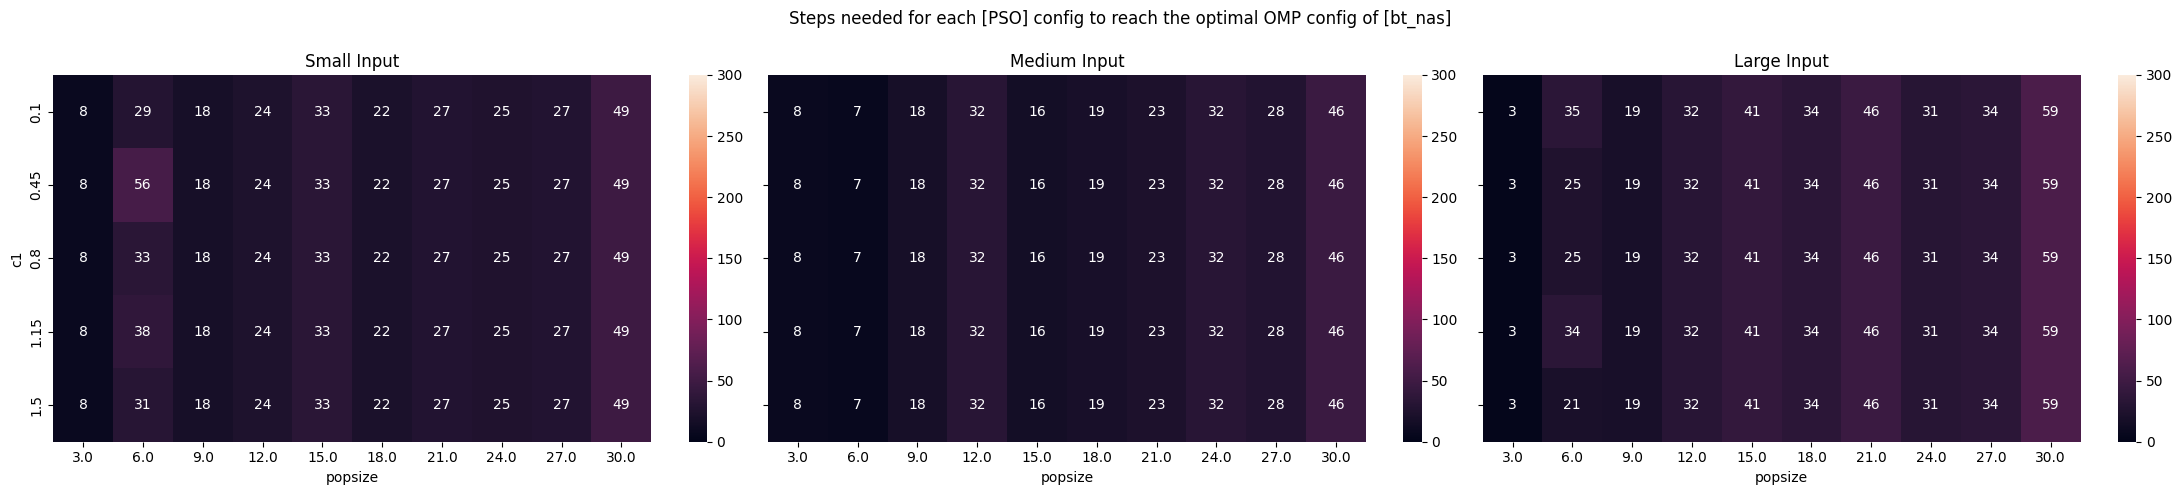

Number of configs that reached the optimal 21831
uniques [0.0, 0.01, 0.02, 0.04, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.12, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23]


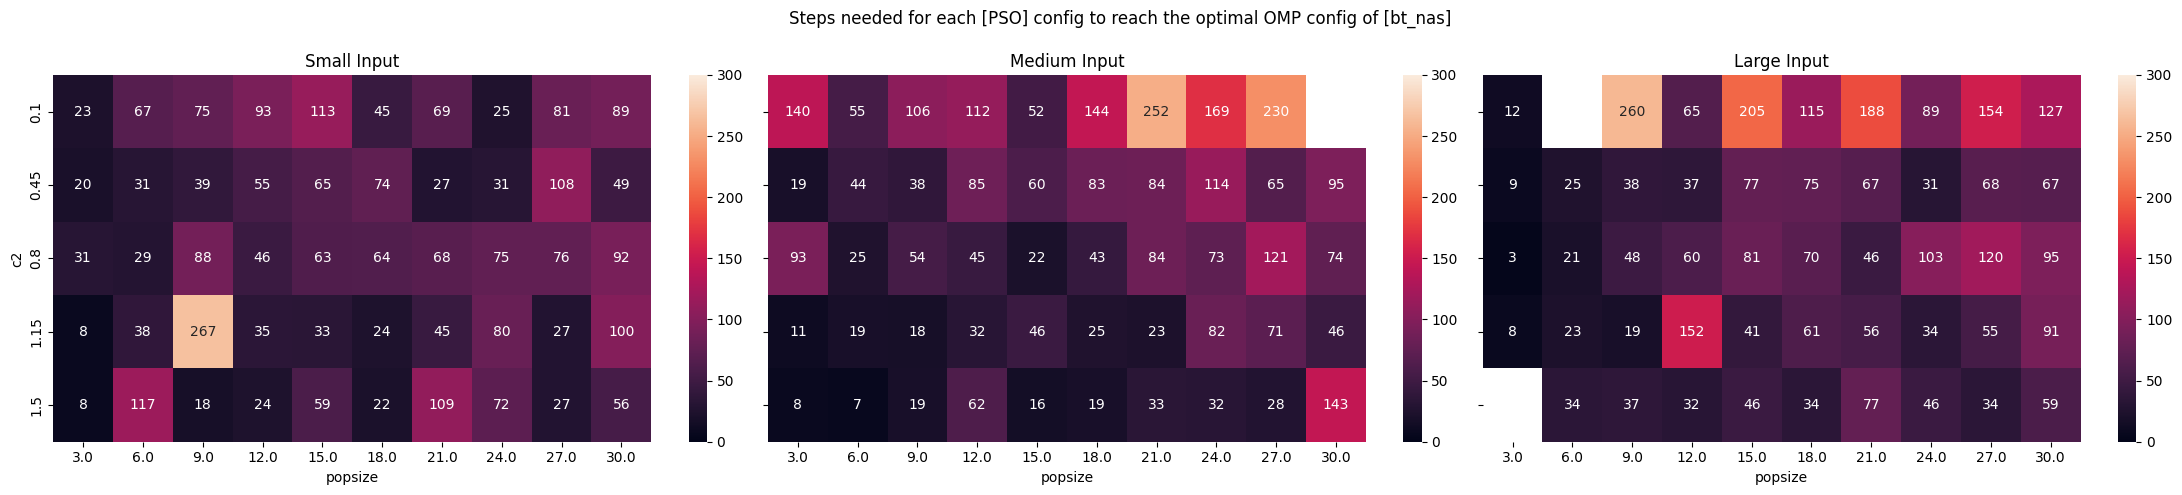

In [292]:
plotHeatmapsForAllCodes()

In [298]:
pd.set_option('display.max_rows', 500)

filename = ROOT_DIR+'/databases/'+f'ruby-bt_nas-cma-GO_Data.csv'
fullDF = pd.read_csv(filename)

print(fullDF.columns)
subset = fullDF[(fullDF['popsize'] == 6) & (fullDF['sigma'] == 4.222) & (fullDF['seed'] == 9999) & (fullDF['probsize'] == 'smlprob')]

print(subset)



Index(['progname', 'probsize', 'method', 'seed', 'globalSample', 'optimXtime',
       'xtime', 'sigma', 'popsize'],
      dtype='object')
      progname probsize method  seed  globalSample  optimXtime     xtime   
63300   bt_nas  smlprob    cma  9999           0.0    0.000074  0.000000  \
63301   bt_nas  smlprob    cma  9999           1.0    0.000074  0.655030   
63302   bt_nas  smlprob    cma  9999           2.0    0.000074  0.000000   
63303   bt_nas  smlprob    cma  9999           3.0    0.000074  0.855606   
63304   bt_nas  smlprob    cma  9999           4.0    0.000074  0.242901   
63305   bt_nas  smlprob    cma  9999           5.0    0.000074  0.000000   
63306   bt_nas  smlprob    cma  9999           6.0    0.000088  0.000000   
63307   bt_nas  smlprob    cma  9999           7.0    0.000088  0.000000   
63308   bt_nas  smlprob    cma  9999           8.0    0.000088  0.248119   
63309   bt_nas  smlprob    cma  9999           9.0    0.000088  0.920821   
63310   bt_nas  smlprob   